Nedir https://medium.com/novaresearchlab/öğrenme-aktarımı-transfer-learning-c0b8126965c4

Verimizi indirelim ve zipten cikartalim. Bu sefer toplam verimizin sadece %10 unu kullanacagiz.

In [1]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-01-27 11:25:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   224MB/s    in 0.7s    

2022-01-27 11:25:22 (224 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



Hangi dosya yolunda ne kadar verimiz olduguna bakalim

In [2]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

Verilerimizi hazirlayalim

ImageDataGenerator ile kolayca halledecegiz

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Callbacks

Bircok callback vardir bunlar bircok acidan islevselligi arttirir. Birkacina bakalim.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

**TensorBoard Callbacks** : Modelin sureclerini goruntulemek gibi bircok ise yarar.
Bir fonksiyon yazalim ve ne ise yaradigini anlamaya calisalim.

In [4]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

**TensorflowHub** https://www.tensorflow.org/hub hazir modelleri dogrudan kullanmak icin kulanacagiz.

Cesitli model mimarileri gibi faydali icerikler bulabilecgin site  https://paperswithcode.com

Kullanacagimiz https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [5]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNetB0 feature vector 
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

bu fonksiyon ile tensorflowHub uzerinden modeli dogrudan cekmis olacagiz. Ogrenilmis olan oruntuleri(pattern) tekrar ogrenmesina gerek kalmicak.

In [7]:
def create_model(model_url, num_classes=10):
 
  
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # kendi modelimize ekleyelim
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

ResNet modeli icin

In [8]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


goruldugu gibi Non-trainable params sayisi olduklca fazla cunku model daha onceden egitilmis bir model.

In [10]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  #burda callback imizi ekliyoruz
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220127-112541
Epoch 1/5
24/24 [==============================] - 53s 1s/step - loss: 1.8186 - accuracy: 0.3800 - val_loss: 1.1869 - val_accuracy: 0.6224
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.8801 - accuracy: 0.7387 - val_loss: 0.8952 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 23s 998ms/step - loss: 0.6179 - accuracy: 0.8173 - val_loss: 0.7732 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.4660 - accuracy: 0.8747 - val_loss: 0.7260 - val_accuracy: 0.7640
Epoch 5/5
24/24 [==============================] - 48s 2s/step - loss: 0.3809 - accuracy: 0.8987 - val_loss: 0.7052 - val_accuracy: 0.7692


sadece verimizin %10 u ile iyi degerler elde ettik bu bize tranfer learningin gücü görmemiz için bir veri

model performansını grafikte inceleyim

In [12]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
 
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

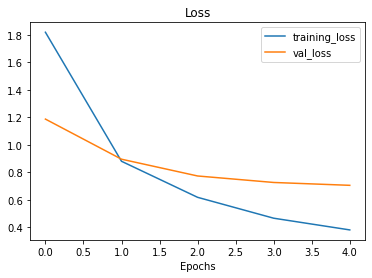

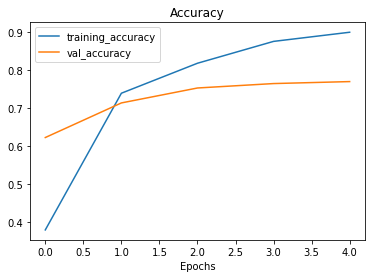

In [13]:
plot_loss_curves(resnet_history)

# EfficientNetB0 

In [17]:
from gc import callbacks
efficientnet_model = create_model(model_url= efficientnet_url,
                                  num_classes= train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer= tf.keras.optimizers.Adam(),
                           metrics= ["accuracy"] 
)

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data_10_percent),
                                              validation_data = test_data ,
                                              validation_steps = len(test_data),
                                              callbacks= [create_tensorboard_callback(dir_name = "tensorflow_hub",
                                                                                      experiment_name = "efficient")]
                                              )


Saving TensorBoard log files to: tensorflow_hub/efficient/20220127-115539
Epoch 1/5
24/24 [==============================] - 31s 864ms/step - loss: 1.8640 - accuracy: 0.4173 - val_loss: 1.3308 - val_accuracy: 0.7176
Epoch 2/5
24/24 [==============================] - 19s 824ms/step - loss: 1.0706 - accuracy: 0.7480 - val_loss: 0.8827 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 22s 936ms/step - loss: 0.7578 - accuracy: 0.8360 - val_loss: 0.7093 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 19s 812ms/step - loss: 0.6086 - accuracy: 0.8667 - val_loss: 0.6196 - val_accuracy: 0.8484
Epoch 5/5
24/24 [==============================] - 19s 812ms/step - loss: 0.5142 - accuracy: 0.8840 - val_loss: 0.5679 - val_accuracy: 0.8532


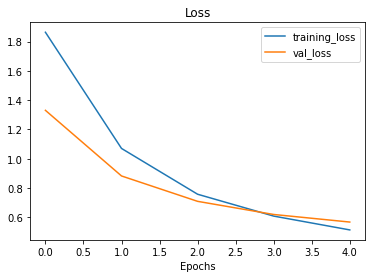

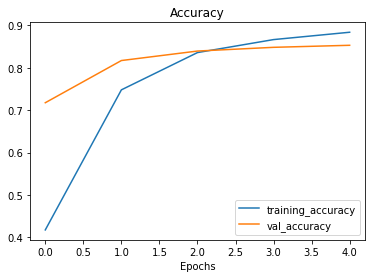

In [18]:
plot_loss_curves(efficientnet_history)

In [19]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [20]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


İki farklı modelin gösterdiği performansı ve detaylarını inceleyelim.

## TensorBoard

Modellerimizi TensorBoard üzerinden karşılaştıralım veya detaylarına bakalım.
Tensorboard birçok yararlı aracı var bakalım deneyelim tecrübe edelim.

In [22]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2"  \
--description "Kıyaslama için bir açıklama yazmak gerekiyordu üşendim" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=wShRlxlHUoHjlGL8AfsqTWXLyYMoFX&prompt=consent&access_type=off

Tensorboardu kullandığımızda verilerimizin public olduğunu unutmayalım.